╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 10. CNN Architectures**
# Section 7. Batch Normalization을 통한 VGG19 학습하기

### _Objective_

1. Batch Normalization을 VGG19에 포함시킨 후, 어떤식으로 학습하는지 배워보도록 하겠습니다.<br>
  
╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import shutil

!pip install tensorboardcolab
import tensorboardcolab

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## Graph Visualization

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 예제 데이터셋) CIFAR-100

In [0]:
from tensorflow.keras.datasets.cifar100 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

In [0]:
class Dataset:
    # fix me #

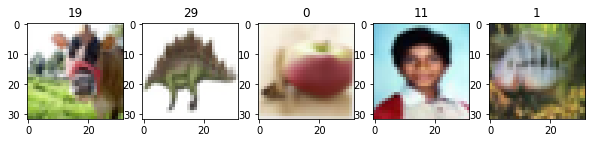

In [0]:
# 이미지 시각화하기
train_set = Dataset(train_x,train_y)
num_sample = 5

sample_x, sample_y = train_set.next_batch(num_sample)

fig = plt.figure(figsize=(10,3))
axes = fig.subplots(1,num_sample)

for ax, image, label in zip(axes, sample_x, sample_y):
    ax.set_title(label)
    ax.imshow(image)
plt.show()

<br>

# \[ 1. BatchNormalization을 포함한 VGG 19 구성하기 \]

---
---

> *Batch Normalization이 나온 후, 많은 인공 신경망에서는 Fully Connected Layer 혹은  Convolution Layer 이후에 추가하였습니다.* <br>
> *Batch Normalization을 통해, 복잡한 Transfer Learning 없이도 VGG 19를 한번에 학습시킬 수 있게 되었습니다.* <br>

<br>

## 1. Batch Normalization Layer을 추가시키기
----

* 논문에서는 Activation Function 이전에 Batch Normalization Layer을 포함시켰습니다.<br>
* 하지만, Activation Function 이후에 Batch Normalization Layer을 포함시켜야, Activation Function으로 인한 분포의 변화가 발생하지 않기 때문입니다.<br>
* 심지어 실험을 했을 때, Activation Function 이후에 Batch Normalization Layer을 포함시켰을 때, 성능 향상이 더 좋았다는 보고도 있습니다.<br>

참고 : [reddit - Batch Normalization before or after ReLU](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)

### (1) Convolution Network 구성하기

![Imgur](https://i.imgur.com/YeoF2AE.png)

* 이전과 동일하되, Convolution Layer와 Fully Connected 이후에 Batch Normalization을 포함시키도록 하겠습니다. 
* Batch Normalization은 약간의 정규화 효과가 있기 때문에, Dropout의 Rate을 50%에서 40%로 줄이겠습니다.


> 텐서플로우에서는 Batch Normalization에 대한 High-API를 제공하고 있습니다.<br>
````python
tf.layers.BatchNormalization()(inputs, training=is_train)
````
inputs에는 입력할 텐서, training에는 Train/Test를 결정하는 Boolean Tensor가 들어갑니다.

In [0]:
input_shape = (None,32,32,3) # Cifar-100 이미지 크기
num_classes = 100 # cifar-100 클래스 수

graph = tf.Graph()
with graph.as_default():
    #fix me #

### (2) Dense Network 구성하기

In [0]:
dropout_ratio = 0.4
with graph.as_default():
    with tf.variable_scope('FC'):
        #fix me#

        
    logits = tf.identity(logits,name='logits')
    pred = tf.nn.softmax(logits,name='predictions')

### (3) Loss 함수 구성하기

![Imgur](https://i.imgur.com/N9VrGkE.png)

Batch Normalization을 적용하면, Weight Decay 값을 이전보다 줄여도 되고, 줄이는 것이 보다 성능 향상을 가져온다고 합니다.<Br>


In [0]:
weight_decay = 1e-4 # 5e-4 -> 1e-4로 줄임
with graph.as_default():
    with tf.variable_scope("losses"):
        #fix me#
    loss = tf.identity(loss, name='loss')

Instructions for updating:
Use tf.cast instead.


### (4) Optimizer 구성하기

````python
tf.layers.BatchNormalization()(inputs, training=is_train)
````
으로 Batch Normalization을 구성하였을 때, 잊지 않고 구성해야하는 것이 있습니다.<br>
위의 High-API를 이용하면, Batch Normalization 내부의 변수인 `mean`과 `variance`를 학습때마다 갱신해주어야 합니다.<br>

train_op를 실행할 때마다 `mean`과 `variance`를 갱신하려면, 아래와 같이 `tf.control_dependencies`를 이용하면 됩니다. <br>


In [0]:
# 평균값과 분산에 대한 지수이동평균해주는 코드들
update_ops = graph.get_collection(tf.GraphKeys.UPDATE_OPS)
update_ops[:10]

[<tf.Operation 'VGGBlock-1/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'VGGBlock-1/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'VGGBlock-1/batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'VGGBlock-1/batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'VGGBlock-2/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'VGGBlock-2/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'VGGBlock-2/batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'VGGBlock-2/batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'VGGBlock-3/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'VGGBlock-3/batch_normalization/AssignMovingAvg_1' type=AssignSub>]

In [0]:
momentum = 0.9
with graph.as_default():
    lr = tf.placeholder_with_default(1e-2,(),name='learning_rate')    
    global_step = tf.train.get_or_create_global_step()
    with tf.variable_scope("optimizer"):
        update_ops = #fix me #
        with tf.control_dependencies(update_ops):
            #fix me #

### (4) Metric 구성하기

In [0]:
with graph.as_default():
    with tf.variable_scope('metrics'):
        #fix me #

<br>

## 2. 모델 학습시키기
----



### (1) 데이터 셋 구성하기


In [0]:
(train_x, train_y), (test_x, test_y) = load_data()
train_y = train_y.reshape((-1,)) # (None, 1) -> (None, )
test_y = test_y.reshape((-1,)) # (None, 1) -> (None, )

train_set = Dataset(train_x,train_y)
test_set = Dataset(test_x,test_y)

### (2) Data Augmentation 적용하기

이전 Section에서 배웠던 몇 가지 Data Augmentation 기법을 활용해 보도록 하겠습니다.<br>

In [0]:
#fix me#

### (2) 학습과정을 기록할 Tensorboard 구성하기

In [0]:
# LOG PATH Setting
LOG_DIR = "./log"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

train_writer = tf.summary.FileWriter(LOG_DIR+"/train", graph)
test_writer = tf.summary.FileWriter(LOG_DIR+"/test")

### (3) 세션 초기화하기

In [0]:
# 변수 초기화 및 Operation 가져오기
sess = tf.Session(graph=graph)
with graph.as_default():
    sess.run(#fix me#)

### (4) 모델 학습하기 

In [0]:
num_epoch = 50
num_batch = 128
num_data = len(train_set)

for epoch in range(num_epoch):
    # Fitting Model  
    for step in tqdm(range(num_data//num_batch)):
       #fix me#

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/07

---